## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB7',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 128,
 'EPOCHS': 12,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'EfficientNetB7',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'# KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


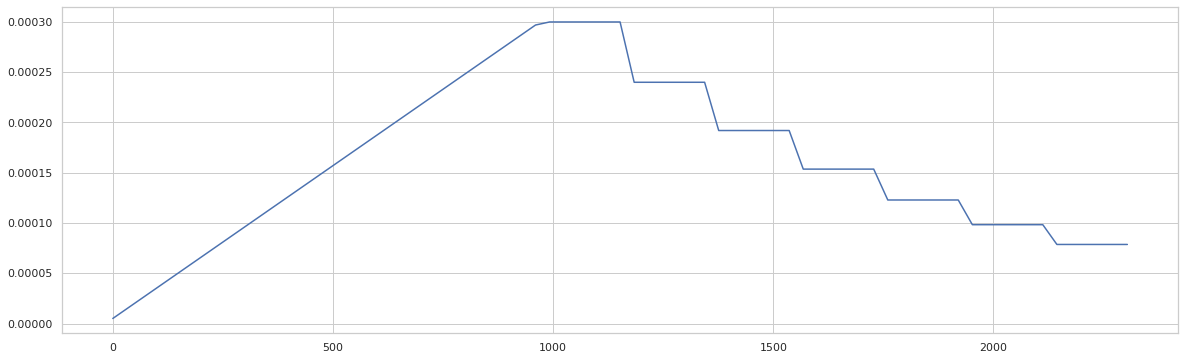

In [8]:
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB7(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights('last_' + model_path)

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1
258072576/258068648 [==============================] - 10s 0us/step
Epoch 1/12
194/194 - 106s - loss: 1.4518 - auc: 0.5943 - val_loss: 0.1802 - val_auc: 0.5265
Epoch 2/12
194/194 - 74s - loss: 0.6995 - auc: 0.7466 - val_loss: 0.2035 - val_auc: 0.8244
Epoch 3/12
194/194 - 74s - loss: 0.5974 - auc: 0.8036 - val_loss: 0.6725 - val_auc: 0.8323
Epoch 4/12
194/194 - 74s - loss: 0.5380 - auc: 0.8201 - val_loss: 0.4355 - val_auc: 0.8457
Epoch 5/12
194/194 - 74s - loss: 0.5532 - auc: 0.8269 - val_loss: 0.4029 - val_auc: 0.8595
Epoch 6/12
194/194 - 73s - loss: 0.5209 - auc: 0.8412 - val_loss: 0.4147 - val_auc: 0.8644
Epoch 7/12
194/194 - 74s - loss: 0.4800 - auc: 0.8679 - val_loss: 0.3315 - val_auc: 0.8718
Epoch 8/12
194/194 - 74s - loss: 0.4660 - auc: 0.8798 - val_loss: 0.3344 - val_auc: 0.8814
Epoch 9/12
194/194 - 68s - loss: 0.4469 - auc: 0.8950 - val_loss: 0.2963 - val_auc: 0.8769
Epoch 10/12
194/194 - 68s - loss: 0.4323 - auc: 0.9014 - val_loss: 0.3758 - val_auc: 0.8747
Epoch 11/12

## Model loss graph

Fold: 1


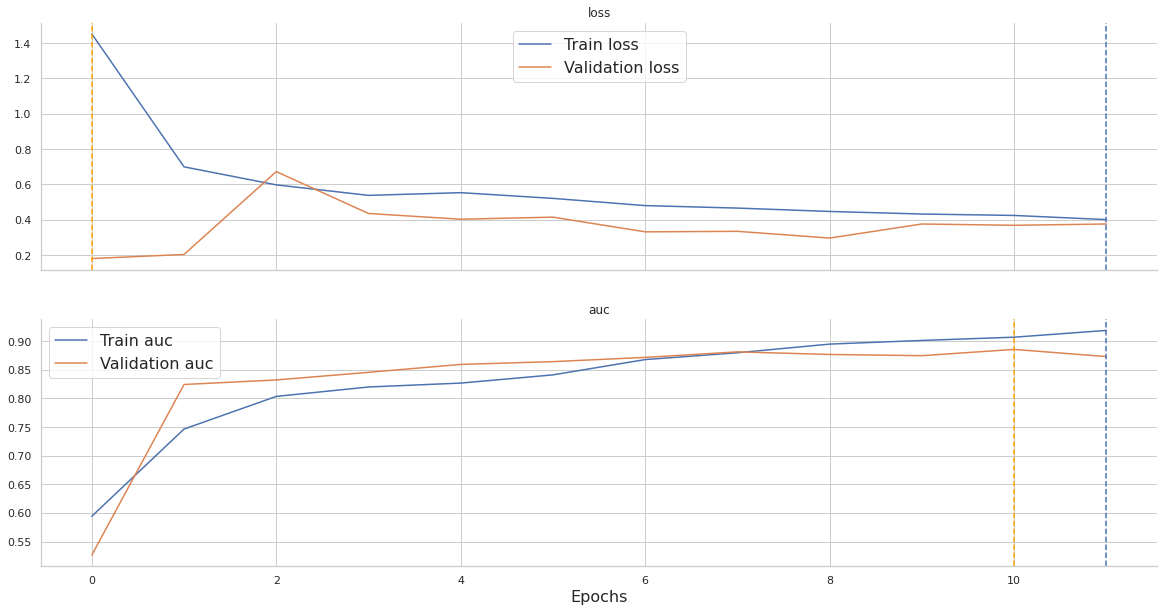

Fold: 2


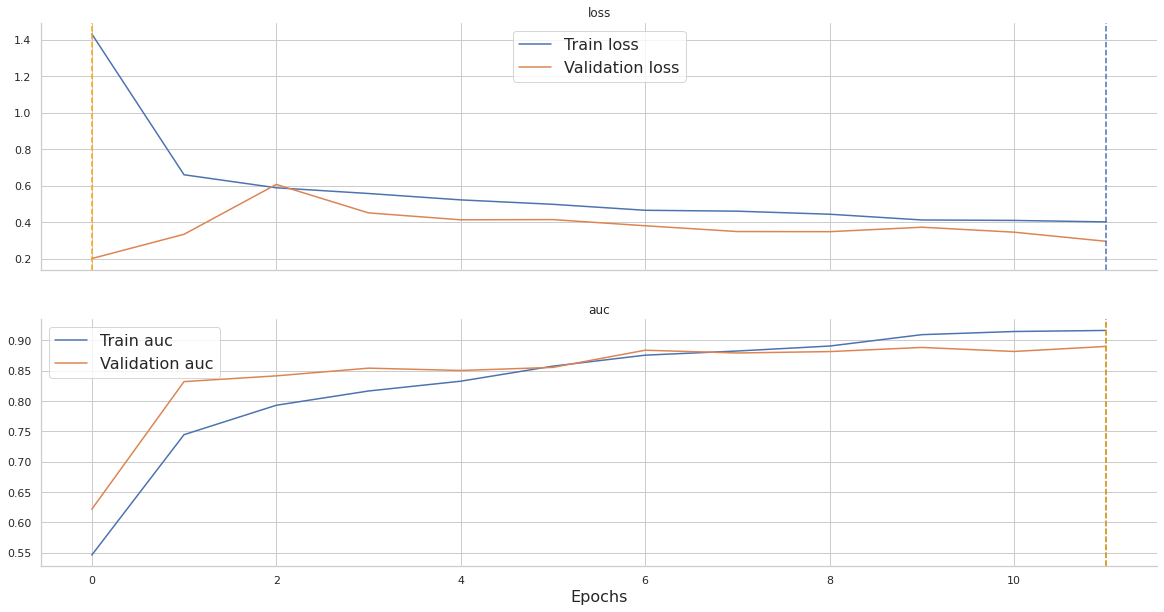

Fold: 3


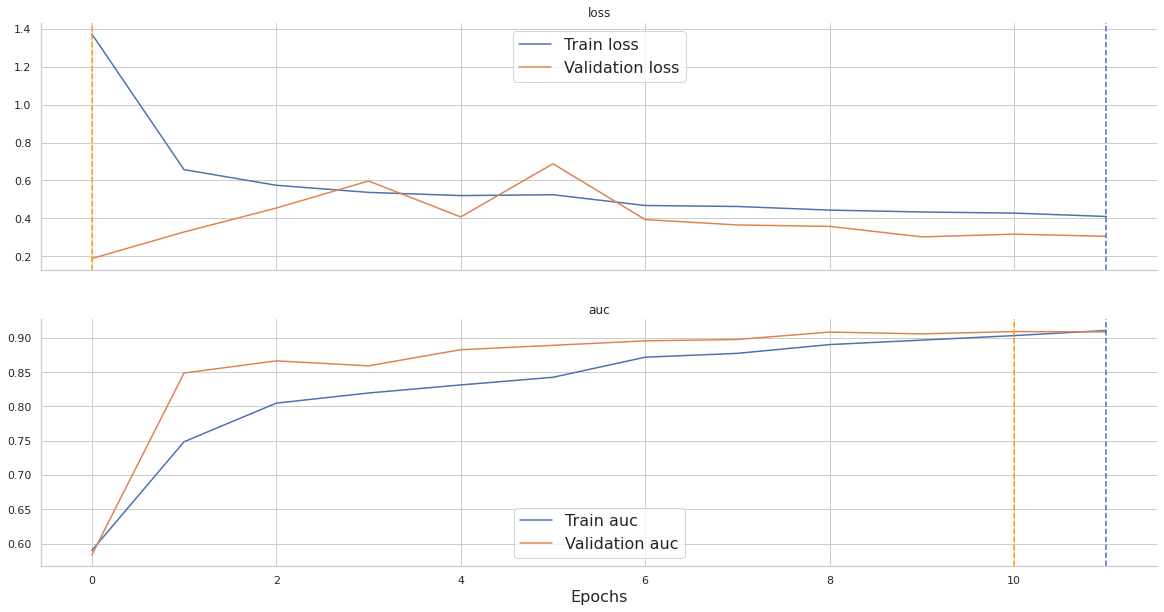

Fold: 4


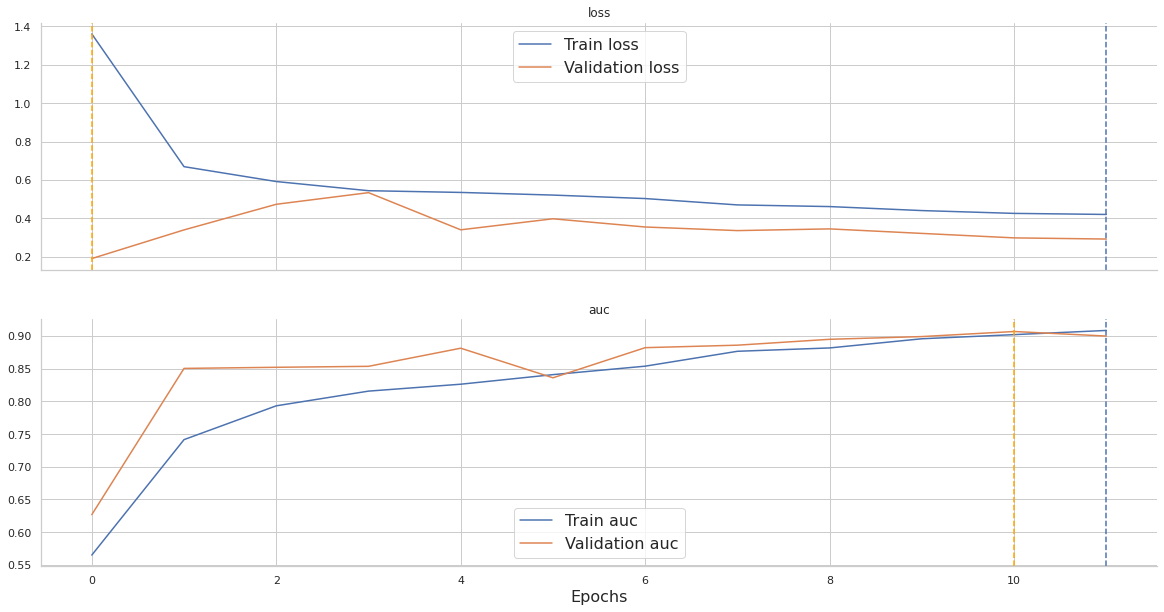

Fold: 5


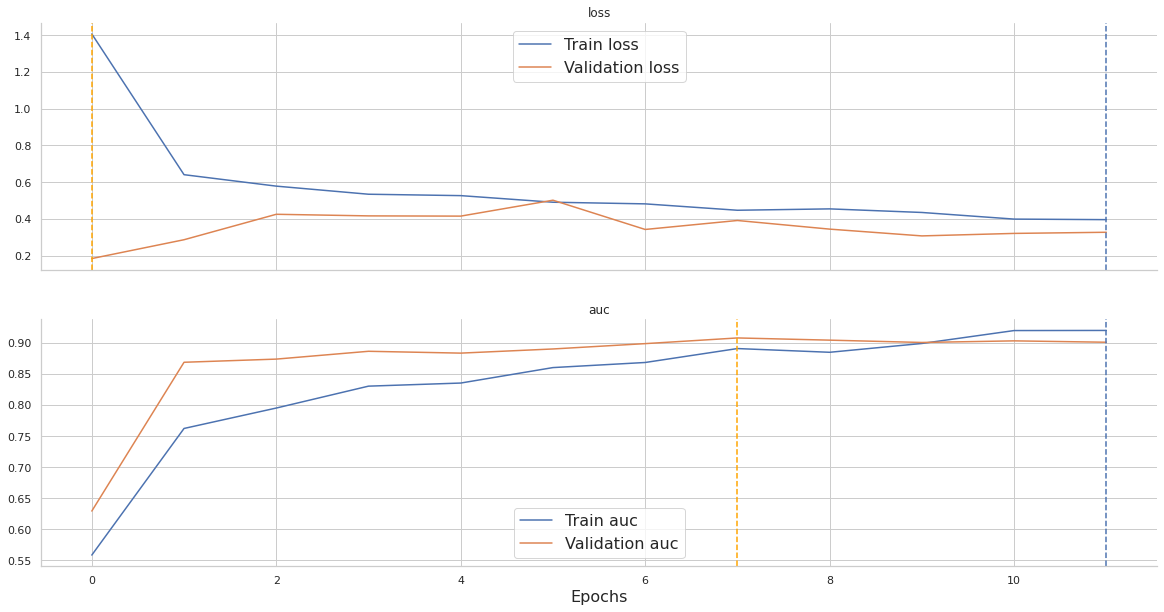

In [12]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

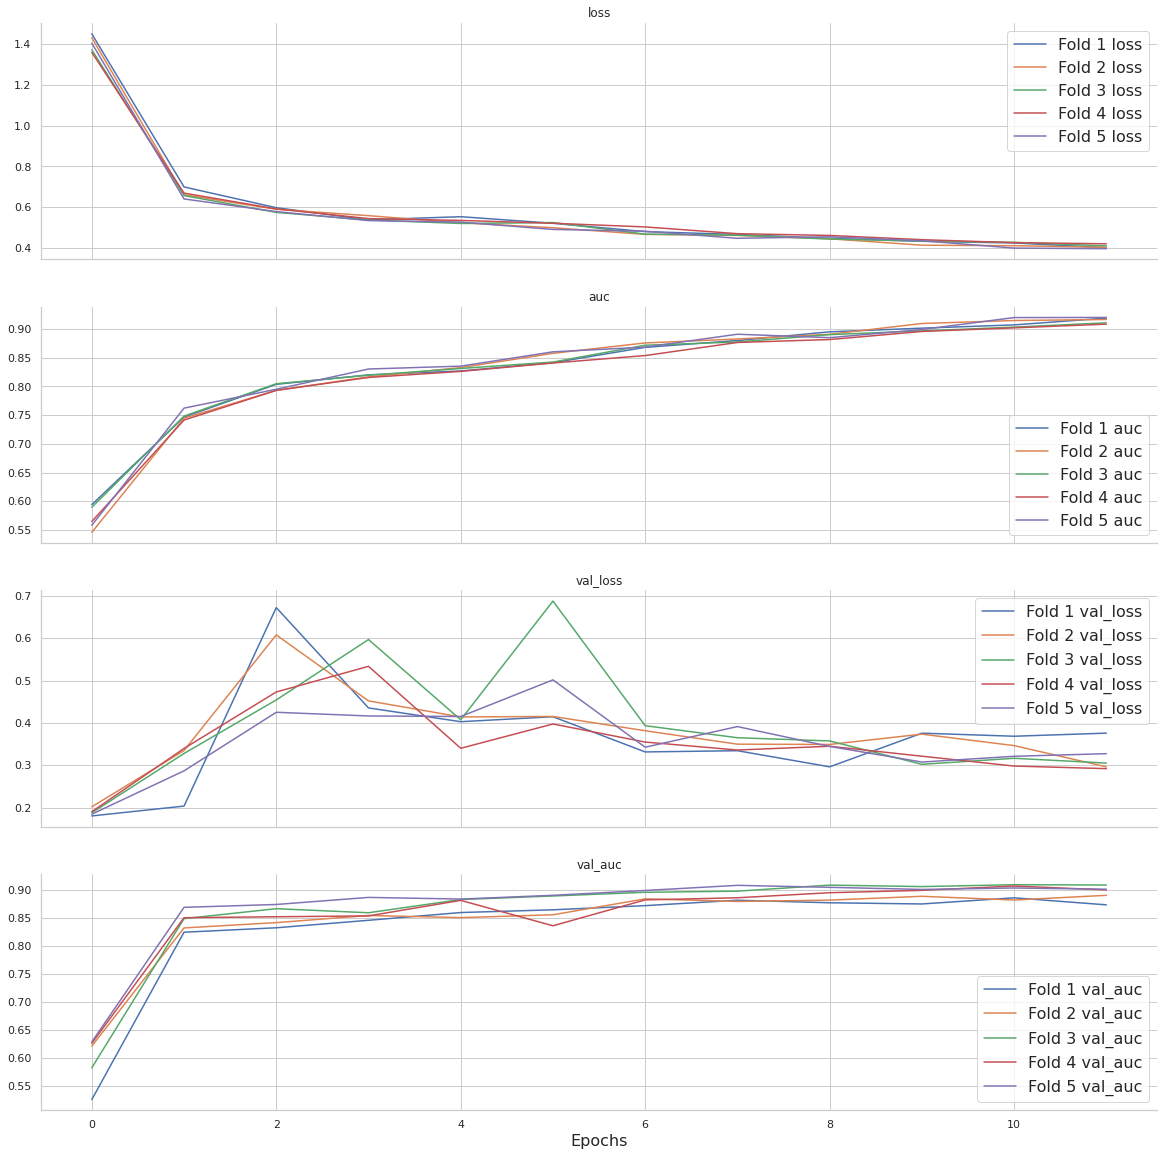

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (last)

In [14]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.961015,0.893921,0.067093,0.958004,0.872808,0.965653,0.888850,0.963317,0.907202,0.950211,0.900075,0.967889,0.900672
Accuracy,0.895203,0.886087,0.009116,0.874487,0.859850,0.913239,0.897151,0.895887,0.885723,0.907551,0.903595,0.884851,0.884114
Precision,0.134597,0.098046,0.036551,0.116212,0.078512,0.157779,0.093702,0.134066,0.106719,0.137621,0.111821,0.127309,0.099476
Recall,0.895697,0.654764,0.240932,0.914221,0.673759,0.905063,0.554545,0.906582,0.716814,0.811441,0.625000,0.941176,0.703704
F1-score,0.233625,0.170149,0.063476,0.206212,0.140637,0.268713,0.160315,0.233589,0.185780,0.235330,0.189702,0.224280,0.174312
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.961015,0.893921,0.067093,0.958004,0.872808,0.965653,0.888850,0.963317,0.907202,0.950211,0.900075,0.967889,0.900672
male,0.958524,0.899971,0.058554,0.952991,0.882916,0.965467,0.883190,0.960371,0.923492,0.949293,0.906360,0.964500,0.903897
female,0.963118,0.880759,0.082359,0.963995,0.856010,0.964849,0.891419,0.966302,0.870192,0.949487,0.890469,0.970957,0.895704
head/neck,0.951295,0.877078,0.074217,0.938756,0.890814,0.938217,0.832899,0.955279,0.945820,0.959202,0.856100,0.965022,0.859756
upper extremity,0.963131,0.897662,0.065469,0.962841,0.858888,0.970154,0.898053,0.967338,0.913309,0.952125,0.927402,0.963197,0.890656
lower extremity,0.955600,0.858050,0.097550,0.955883,0.838692,0.967821,0.831708,0.955174,0.891523,0.934475,0.875821,0.964646,0.852503
torso,0.963573,0.907576,0.055996,0.959251,0.881474,0.966284,0.921507,0.965533,0.910185,0.955767,0.903116,0.971029,0.921600
0 <= age < 26,0.949786,0.847162,0.102624,0.930355,0.960490,0.973668,0.733179,0.969644,0.864508,0.946382,0.815284,0.928884,0.862351
26 <= age < 40,0.956327,0.870417,0.085911,0.955530,0.858740,0.957484,0.823692,0.965622,0.863309,0.931594,0.894424,0.971407,0.911918


# Model evaluation (best)

In [15]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.954760,0.899402,0.055358,0.960550,0.884664,0.965444,0.889154,0.960804,0.909099,0.952914,0.906704,0.934086,0.907388
Accuracy,0.879810,0.872253,0.007557,0.868046,0.852970,0.913796,0.897956,0.891651,0.882343,0.909408,0.904724,0.816148,0.823274
Precision,0.124528,0.093784,0.030744,0.111750,0.080934,0.158401,0.094427,0.128306,0.102828,0.142753,0.113086,0.081430,0.077645
Recall,0.893281,0.693538,0.199743,0.920993,0.737589,0.902954,0.554545,0.895966,0.707965,0.832627,0.625000,0.913866,0.842593
F1-score,0.217312,0.164104,0.053209,0.199316,0.145863,0.269521,0.161376,0.224468,0.179574,0.243721,0.191518,0.149536,0.142187
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.954760,0.899402,0.055358,0.960550,0.884664,0.965444,0.889154,0.960804,0.909099,0.952914,0.906704,0.934086,0.907388
male,0.952636,0.906222,0.046414,0.957283,0.897746,0.964752,0.884154,0.957863,0.921970,0.953282,0.909162,0.930002,0.918081
female,0.956073,0.885774,0.070298,0.963647,0.863678,0.965345,0.890436,0.963615,0.878748,0.949990,0.902032,0.937767,0.893978
head/neck,0.938734,0.882286,0.056448,0.948927,0.902791,0.938849,0.833116,0.947552,0.929102,0.957947,0.867356,0.900395,0.879065
upper extremity,0.958173,0.900227,0.057946,0.964446,0.867817,0.969764,0.898053,0.965149,0.912622,0.956848,0.925367,0.934658,0.897275
lower extremity,0.946920,0.873328,0.073592,0.951678,0.856953,0.967766,0.832681,0.954251,0.887813,0.935136,0.894696,0.925770,0.894495
torso,0.958417,0.911083,0.047333,0.964243,0.894385,0.965785,0.921766,0.962394,0.914150,0.958062,0.909304,0.941599,0.915810
0 <= age < 26,0.943970,0.853842,0.090128,0.933685,0.964336,0.974776,0.735499,0.955160,0.842326,0.946720,0.824891,0.909508,0.902158
26 <= age < 40,0.947232,0.872072,0.075160,0.947225,0.872375,0.959086,0.822351,0.966615,0.883906,0.938518,0.885835,0.924716,0.895893


# Confusion matrix

Fold: 1


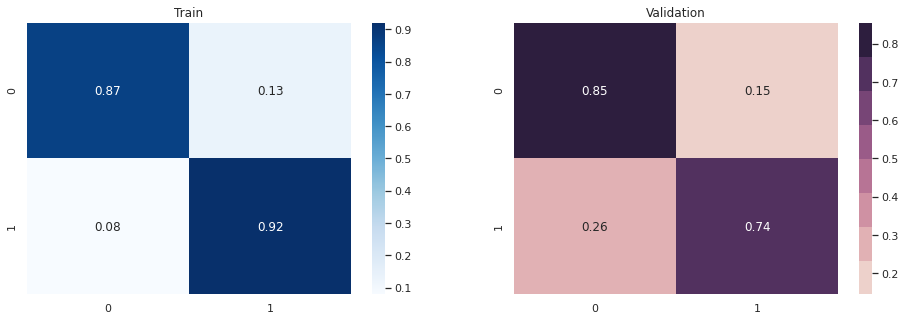

Fold: 2


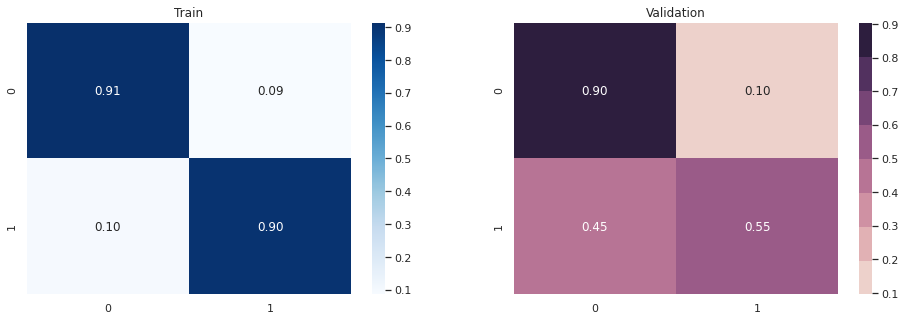

Fold: 3


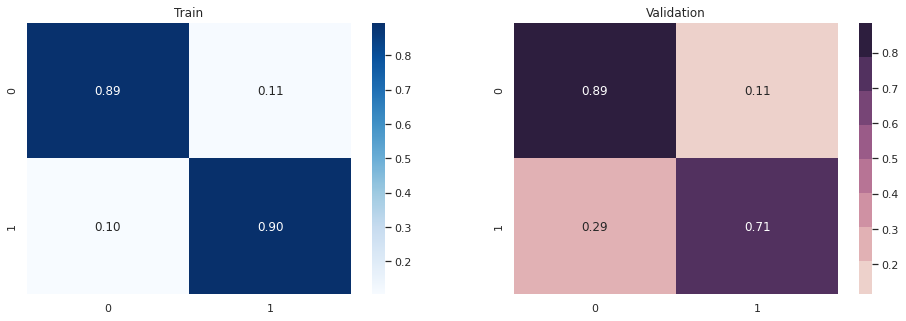

Fold: 4


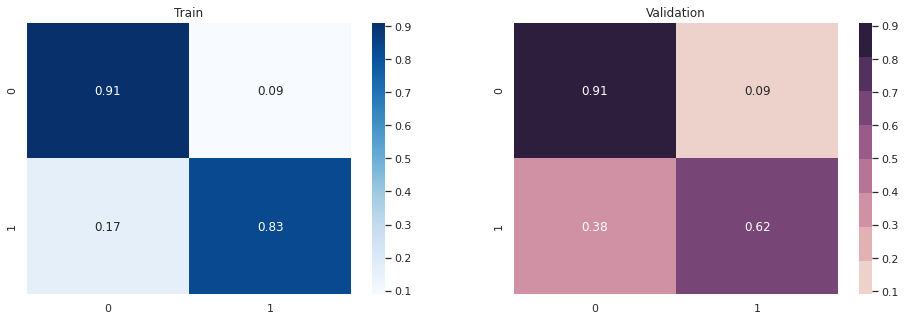

Fold: 5


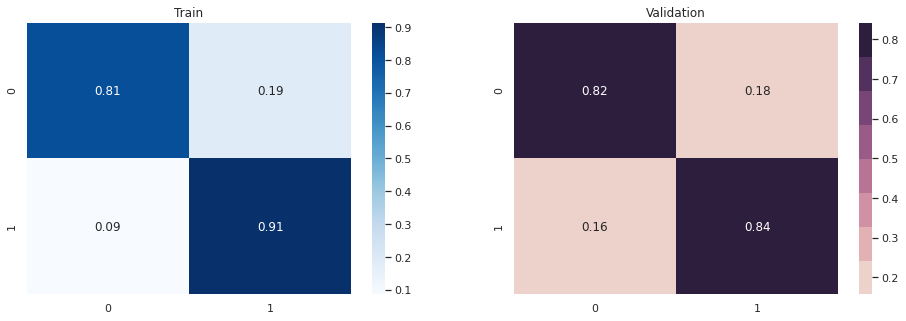

In [16]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [17]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 3637
Train positive correct predictions: 518
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.122717,0.207876,0.054583,0.128559,0.031564,0.191004
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.021538,0.013912,0.016591,0.008907,0.023310,0.044968
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.038786,0.058774,0.025889,0.037226,0.021306,0.050736
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.378055,0.471496,0.260491,0.398987,0.259272,0.500028
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.014019,0.004093,0.015686,0.006304,0.014182,0.029829
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.021647,0.015352,0.023079,0.009287,0.014669,0.045847
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.209809,0.228343,0.220655,0.119677,0.088594,0.391778
7,ISIC_0075663,female,35.0,torso,unknown,0,0.299653,0.205475,0.379610,0.385218,0.423913,0.104052
8,ISIC_0075914,male,30.0,torso,unknown,0,0.045850,0.109502,0.018160,0.027603,0.007650,0.066334
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.115724,0.373430,0.084919,0.030980,0.010158,0.079134


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.653725,0.023354,0.867031,0.544980,0.875785,0.957476
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.919526,0.954313,0.961947,0.802374,0.936191,0.942805
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.601761,0.426179,0.824008,0.331400,0.649162,0.778058
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.643972,0.454482,0.546359,0.792596,0.761058,0.665366
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.899035,0.833802,0.899633,0.876688,0.949858,0.935191
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.869297,0.968353,0.811321,0.869385,0.893267,0.804158
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.641393,0.945876,0.448256,0.767700,0.535548,0.509584
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.646573,0.164239,0.525045,0.861038,0.783961,0.898582
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.739789,0.847590,0.532476,0.763289,0.767471,0.788121
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.808368,0.958850,0.837999,0.541436,0.862286,0.841267


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.783025,0.701483,0.649902,0.920354,0.767784,0.875603
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.560520,0.413416,0.427489,0.596302,0.684822,0.680570
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.653725,0.023354,0.867031,0.544980,0.875785,0.957476
95,ISIC_0150975,female,50.0,lower extremity,unknown,0,0.607952,0.665269,0.471351,0.714170,0.735462,0.453507
110,ISIC_0154880,male,75.0,torso,unknown,0,0.701647,0.704024,0.519691,0.812701,0.761543,0.710278
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.523796,0.730094,0.436445,0.461643,0.700613,0.290188
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.689880,0.761823,0.407068,0.702162,0.802846,0.775504
131,ISIC_0160455,male,75.0,lower extremity,nevus,0,0.679037,0.596701,0.774781,0.819656,0.651173,0.552876
136,ISIC_0162967,male,65.0,head/neck,unknown,0,0.713007,0.889355,0.613208,0.713045,0.691967,0.657460
137,ISIC_0163110,female,40.0,torso,nevus,0,0.641201,0.923870,0.512895,0.733435,0.480748,0.555056


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1830|9152
Test predictions (last) 1539|9443
Test predictions (tta) 1727|9255
Test predictions (last tta) 1483|9499
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.053718,0.045178,0.057112,0.052484
1,ISIC_0052349,male,40.0,lower extremity,0.016947,0.016058,0.022196,0.018846
2,ISIC_0058510,female,55.0,torso,0.013701,0.018909,0.011891,0.015811
3,ISIC_0073313,female,50.0,torso,0.015155,0.017043,0.016156,0.017704
4,ISIC_0073502,female,45.0,lower extremity,0.316966,0.231097,0.150555,0.105390
5,ISIC_0074618,male,50.0,lower extremity,0.157460,0.143841,0.421951,0.359047
6,ISIC_0076801,male,45.0,upper extremity,0.097358,0.078540,0.177780,0.141087
7,ISIC_0077586,male,50.0,lower extremity,0.471902,0.431575,0.490397,0.411683
8,ISIC_0082004,female,45.0,torso,0.476038,0.408142,0.398769,0.338964
9,ISIC_0082785,male,65.0,lower extremity,0.409767,0.375478,0.372226,0.350775


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
14,ISIC_0090283,male,55.0,head/neck,0.586171,0.507003,0.303358,0.255540
18,ISIC_0097719,male,45.0,torso,0.661855,0.651947,0.642227,0.642840
22,ISIC_0105104,male,40.0,torso,0.802902,0.810373,0.530825,0.582952
24,ISIC_0112420,female,65.0,torso,0.845076,0.843641,0.840507,0.827387
33,ISIC_0142066,female,35.0,torso,0.507039,0.442972,0.441592,0.363281
34,ISIC_0143109,male,45.0,upper extremity,0.514424,0.475356,0.522685,0.468463
41,ISIC_0155813,male,55.0,lower extremity,0.687993,0.629624,0.633565,0.589595
42,ISIC_0155983,male,70.0,torso,0.930478,0.944657,0.916005,0.935330
45,ISIC_0161963,male,35.0,upper extremity,0.655753,0.648962,0.664292,0.655655
47,ISIC_0165230,female,35.0,torso,0.628678,0.647985,0.577663,0.588177


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
14,ISIC_0090283,male,55.0,head/neck,0.586171,0.507003,0.303358,0.255540
18,ISIC_0097719,male,45.0,torso,0.661855,0.651947,0.642227,0.642840
22,ISIC_0105104,male,40.0,torso,0.802902,0.810373,0.530825,0.582952
24,ISIC_0112420,female,65.0,torso,0.845076,0.843641,0.840507,0.827387
41,ISIC_0155813,male,55.0,lower extremity,0.687993,0.629624,0.633565,0.589595
42,ISIC_0155983,male,70.0,torso,0.930478,0.944657,0.916005,0.935330
45,ISIC_0161963,male,35.0,upper extremity,0.655753,0.648962,0.664292,0.655655
47,ISIC_0165230,female,35.0,torso,0.628678,0.647985,0.577663,0.588177
56,ISIC_0169906,male,85.0,torso,0.708323,0.723087,0.718039,0.733288
61,ISIC_0175798,female,55.0,torso,0.846636,0.845931,0.864206,0.862733


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv('submission_tta.csv', index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv('submission_tta_last.csv', index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv('submission_blend_tta.csv', index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.053718,0.045178,0.049448,0.057112,0.052484,0.054798
1,ISIC_0052349,0.016947,0.016058,0.016502,0.022196,0.018846,0.020521
2,ISIC_0058510,0.013701,0.018909,0.016305,0.011891,0.015811,0.013851
3,ISIC_0073313,0.015155,0.017043,0.016099,0.016156,0.017704,0.016930
4,ISIC_0073502,0.316966,0.231097,0.274031,0.150555,0.105390,0.127973
5,ISIC_0074618,0.157460,0.143841,0.150651,0.421951,0.359047,0.390499
6,ISIC_0076801,0.097358,0.078540,0.087949,0.177780,0.141087,0.159434
7,ISIC_0077586,0.471902,0.431575,0.451738,0.490397,0.411683,0.451040
8,ISIC_0082004,0.476038,0.408142,0.442090,0.398769,0.338964,0.368866
9,ISIC_0082785,0.409767,0.375478,0.392622,0.372226,0.350775,0.361501


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.240523,0.220432,0.230478,0.234005,0.215086,0.224546
std,0.236315,0.229574,0.232238,0.229926,0.224402,0.226506
min,0.006478,0.007331,0.006905,0.006470,0.007556,0.007013
25%,0.034226,0.032651,0.033925,0.034287,0.032597,0.033636
50%,0.156741,0.127877,0.143769,0.152683,0.126549,0.139829
75%,0.398750,0.347665,0.373894,0.383405,0.335998,0.359733
max,0.975321,0.982609,0.978965,0.962862,0.976576,0.969719
